#### import all the necessary libraries
import pandas as pd
import numpy as np
import csv
import math
import gender_guesser.detector as gender
import nltk
import os
import pycountry

In [ ]:
os.getcwd()

In [3]:
# this is my gender identification dataframe
# using 'andy' as 0.5 isntead of excluding it 
# with this method it is imossible to quantify uncertainty around gender identification of each name 
# we can try and see what we can do with genderizeR (it provides uncertainty for each name)
# or we can try a paid tool

df_gender_m = pd.read_csv('/Users/dianadanilenko/Desktop/personal/master_thesis/methods/python_scripts/data/gender_data.csv')
df_ssa = pd.read_csv('/Users/dianadanilenko/Desktop/personal/master_thesis/methods/R_scripts/data/gender_ssa.csv', usecols = ['name','gender'])
df_ipums = pd.read_csv('/Users/dianadanilenko/Desktop/personal/master_thesis/methods/R_scripts/data/gender_ipums.csv', usecols = ['name','gender'])
df_gender_m = pd.merge(df_gender_m,df_ssa, how = 'left', on = 'name')
df_gender_m.rename(columns={'gender': 'ssa'}, inplace=True)
df_gender_m = pd.merge(df_gender_m,df_ipums, how = 'left', on = 'name')
df_gender_m.rename(columns={'gender': 'ipums'}, inplace=True)
for row in df_gender_m.index:
    if df_gender_m.loc[row,'gender_guesser'] == 'unknown':
        df_gender_m.loc[row,'gender_guesser'] = np.nan
    #elif df_gender_m.loc[row,'gender_guesser'] == 'andy':
        #df_gender_m.loc[row,'gender_guesser'] = np.nan
    elif df_gender_m.loc[row,'gender_guesser'] == 'mostly_male':
        df_gender_m.loc[row,'gender_guesser'] = 'male'
    elif df_gender_m.loc[row,'gender_guesser'] == 'mostly_female':
        df_gender_m.loc[row,'gender_guesser'] = 'female'
for row in df_gender_m.index:
    if df_gender_m.loc[row,'wiki'] == 'unknown':
        df_gender_m.loc[row,'wiki'] = np.nan
    #elif df_gender_m.loc[row,'wiki'] == 'andy':
        #df_gender_m.loc[row,'wiki'] = np.nan
df_gender_m['prob_female'] = np.nan
for row in df_gender_m.index:
    allpredictions = []
    if not pd.isna(df_gender_m.loc[row, 'gender_guesser']):
        allpredictions.append(df_gender_m.loc[row, 'gender_guesser'])
    if not pd.isna(df_gender_m.loc[row, 'ipcc']):
        splitipcc = df_gender_m.loc[row, 'ipcc'].split(',')
        for value in splitipcc:
            allpredictions.append(value)
    if not pd.isna(df_gender_m.loc[row, 'wiki']):
        allpredictions.append(df_gender_m.loc[row, 'wiki'])
    if not pd.isna(df_gender_m.loc[row, 'ssa']):
        allpredictions.append(df_gender_m.loc[row, 'ssa'])
    if not pd.isna(df_gender_m.loc[row, 'ipums']):
        allpredictions.append(df_gender_m.loc[row, 'ipums'])
    try:
        if 'andy' in allpredictions:
            df_gender_m.loc[row,'prob_female'] = (allpredictions.count('female') + 0.5 * allpredictions.count('andy'))/ len(allpredictions)    
        else:
            df_gender_m.loc[row,'prob_female'] = allpredictions.count('female')/ len(allpredictions)
    except ZeroDivisionError:
        pass

In [16]:
# load the documents and authors
# these are a full dataset of documents from query 11087 run in january 2023
# this df contains multiple entries per document id as it is split up by author
# add a column with country gender equality index based on the institutional affilliation of the first author (after consolidation, only keep one institution entry per document id)
mycolumns = ['id','abstract','title','PY','journal','category', 'author_name','institution', 'position', 'relevant', 'seen','keywords']
df = pd.read_csv('/Users/dianadanilenko/Desktop/personal/master_thesis/methods/python_scripts/data/11087_results.csv', names = mycolumns)
df = df.drop(index = 0)
df = df.drop(['relevant', 'seen'], axis=1)
#df.rename(columns={'PY':'year','journal':'publisher'},inplace=True)
unique_count_id = df['id'].nunique()
print(unique_count_id)
# 70,319
display(df)
# N = 366,522 initial dataset (authorships)

/Users/dianadanilenko/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3269: DtypeWarning: Columns (0,3,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


70319


,id,abstract,title,PY,journal,category,author_name,institution,position,keywords
1,611869,"The Vietnamese government, along with country-...",'The weather is like the game we play': Coping...,2016.0,WILEY,Area Studies; Geography,"Turner, Sarah","McGill Univ, Dept Geog, Montreal, PQ, Canada.",2.0,NaN
2,3822524,"In this review, we take stock of the last deca...",Ten years after Copenhagen: Reimagining climat...,2020.0,WILEY,Environmental Sciences & Ecology; Meteorology ...,"Castan Broto, Vanesa","Univ Sheffield, Urban Inst, Sheffield, S Yorks...",1.0,NaN
3,109136,The significant shifts in climate variables pr...,Climate change and the city: Building capacity...,2015.0,PERGAMON-ELSEVIER SCIENCE LTD,Environmental Sciences & Ecology; Public Admin...,"Handley, John","Univ Manchester, Sch Environm & Dev, Mancheste...",5.0,NaN
4,546104,Background/Context: Educators have written abo...,"School Climate: Research, Policy, Practice, an...",2009.0,TEACHERS COLL OF COLUMBIA UNIV,Education & Educational Research,"Michelli, Nicholas M.",NaN,3.0,NaN
5,3861122,This article presents a model of the environme...,Model of Carbon Footprint Assessment for the L...,2020.0,NATURE PORTFOLIO,Science & Technology - Other Topics,"Burchart-Korol, Dorota","Silesian Tech Univ, Ul Krasinskiego 8, PL-4001...",2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
366518,5645675,The proceedings contain 48 papers. The special...,International Conference on Advances in Constr...,2022.0,NaN,NaN,NaN,NaN,NaN,NaN
366519,1803095,"Traditionally, biodiversity conservation gap a...",The Effects of Governmental Protected Areas an...,2009.0,NaN,NaN,NaN,NaN,NaN,NaN
366520,2378632,Lessons learned from Songkhla lake fisheries s...,Partnership-based fisheries management in Song...,2010.0,NaN,NaN,NaN,NaN,NaN,NaN
366521,5338985,The proceedings contain 48 papers. The special...,27th Annual International Scientific Conferenc...,2021.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df['id'] = df['id'].apply(lambda x: int(x) if isinstance(x, str) else x)

In [8]:
# drop NAs later because we don't want to keep only part of the authorships per paper
# this is the dataframe for majority_gender 
# drop duplicated authorship records
# N = 232,029 after dropping duplicates and any papers where any author name is NA
# 49,422 
df_maj = df.drop_duplicates(subset=['id', 'author_name'])
df_maj = df_maj.groupby('id').filter(lambda x: not any(x['author_name'].isna()))
unique_count_id = df_maj['id'].nunique()
print(unique_count_id)
display(df_maj)

49422


,id,abstract,title,year,publisher,category,author_name,institution,position,keywords
1,611869,"The Vietnamese government, along with country-...",'The weather is like the game we play': Coping...,2016.0,WILEY,Area Studies; Geography,"Turner, Sarah","McGill Univ, Dept Geog, Montreal, PQ, Canada.",2.0,NaN
2,3822524,"In this review, we take stock of the last deca...",Ten years after Copenhagen: Reimagining climat...,2020.0,WILEY,Environmental Sciences & Ecology; Meteorology ...,"Castan Broto, Vanesa","Univ Sheffield, Urban Inst, Sheffield, S Yorks...",1.0,NaN
3,109136,The significant shifts in climate variables pr...,Climate change and the city: Building capacity...,2015.0,PERGAMON-ELSEVIER SCIENCE LTD,Environmental Sciences & Ecology; Public Admin...,"Handley, John","Univ Manchester, Sch Environm & Dev, Mancheste...",5.0,NaN
4,546104,Background/Context: Educators have written abo...,"School Climate: Research, Policy, Practice, an...",2009.0,TEACHERS COLL OF COLUMBIA UNIV,Education & Educational Research,"Michelli, Nicholas M.",NaN,3.0,NaN
5,3861122,This article presents a model of the environme...,Model of Carbon Footprint Assessment for the L...,2020.0,NATURE PORTFOLIO,Science & Technology - Other Topics,"Burchart-Korol, Dorota","Silesian Tech Univ, Ul Krasinskiego 8, PL-4001...",2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
366506,35060,Shifts in species' ranges are one of the most ...,Rapid assessment of an ocean warming hotspot r...,2015.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology; Geography,"Gledhill, D. C.","CSIRO Marine & Atmospher Res, CSIRO Wealth Oce...",2.0,NaN
366508,4307291,There is a broad consensus worldwide that anth...,Humanity Can Still Stop Climate Change by Impl...,2020.0,MDPI,Energy & Fuels,"Margeta, Karmen","Univ Zagreb, Fac Chem Engn & Technol, Marulice...",2.0,NaN
366510,4912929,"Light pollution, a phenomenon in which artific...",Evaluation of Light Pollution in Global Protec...,2021.0,MDPI,Environmental Sciences & Ecology; Geology; Rem...,"Yin, Peiyi","China Agr Univ, Coll Land Sci & Technol, Beiji...",8.0,NaN
366512,1299177,This study reports the Brokpa herder's knowled...,Grazing and rangeland management: Trans-human ...,2018.0,NATL INST SCIENCE COMMUNICATION-NISCAIR,Plant Sciences,"Tsering, Darge",NaN,4.0,NaN


In [30]:
df_maj = df_maj[df_maj['id'].notna()]
unique_count_id = df_maj['id'].nunique()
print(unique_count_id)
# 49422
# N = 232027

49422


In [10]:
df_maj["first_name"] = np.nan

# try to find first name of each author and record the id if there are blanks
def extract_first_name(full_name):
    try:
        return full_name.split(",")[1]
    except IndexError:
        return np.nan

df_maj["first_name"] = df_maj["author_name"].apply(extract_first_name)
list_ids = df_maj[df_maj["first_name"].isnull()]["id"].tolist()

In [32]:
df_maj.reset_index(inplace=True, drop=True)
display(df_maj)

,id,abstract,title,year,publisher,category,author_name,institution,position,keywords,first_name
0,611869,"The Vietnamese government, along with country-...",'The weather is like the game we play': Coping...,2016.0,WILEY,Area Studies; Geography,"Turner, Sarah","McGill Univ, Dept Geog, Montreal, PQ, Canada.",2.0,NaN,Sarah
1,3822524,"In this review, we take stock of the last deca...",Ten years after Copenhagen: Reimagining climat...,2020.0,WILEY,Environmental Sciences & Ecology; Meteorology ...,"Castan Broto, Vanesa","Univ Sheffield, Urban Inst, Sheffield, S Yorks...",1.0,NaN,Vanesa
2,109136,The significant shifts in climate variables pr...,Climate change and the city: Building capacity...,2015.0,PERGAMON-ELSEVIER SCIENCE LTD,Environmental Sciences & Ecology; Public Admin...,"Handley, John","Univ Manchester, Sch Environm & Dev, Mancheste...",5.0,NaN,John
3,546104,Background/Context: Educators have written abo...,"School Climate: Research, Policy, Practice, an...",2009.0,TEACHERS COLL OF COLUMBIA UNIV,Education & Educational Research,"Michelli, Nicholas M.",NaN,3.0,NaN,Nicholas M.
4,3861122,This article presents a model of the environme...,Model of Carbon Footprint Assessment for the L...,2020.0,NATURE PORTFOLIO,Science & Technology - Other Topics,"Burchart-Korol, Dorota","Silesian Tech Univ, Ul Krasinskiego 8, PL-4001...",2.0,NaN,Dorota
...,...,...,...,...,...,...,...,...,...,...,...
232024,35060,Shifts in species' ranges are one of the most ...,Rapid assessment of an ocean warming hotspot r...,2015.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology; Geography,"Gledhill, D. C.","CSIRO Marine & Atmospher Res, CSIRO Wealth Oce...",2.0,NaN,D. C.
232025,4307291,There is a broad consensus worldwide that anth...,Humanity Can Still Stop Climate Change by Impl...,2020.0,MDPI,Energy & Fuels,"Margeta, Karmen","Univ Zagreb, Fac Chem Engn & Technol, Marulice...",2.0,NaN,Karmen
232026,4912929,"Light pollution, a phenomenon in which artific...",Evaluation of Light Pollution in Global Protec...,2021.0,MDPI,Environmental Sciences & Ecology; Geology; Rem...,"Yin, Peiyi","China Agr Univ, Coll Land Sci & Technol, Beiji...",8.0,NaN,Peiyi
232027,1299177,This study reports the Brokpa herder's knowled...,Grazing and rangeland management: Trans-human ...,2018.0,NATL INST SCIENCE COMMUNICATION-NISCAIR,Plant Sciences,"Tsering, Darge",NaN,4.0,NaN,Darge


In [34]:
df_maj = df_maj[~df_maj['id'].isin(list_ids)].reset_index(drop=True)
display(df_maj)
# 224,528
unique_count_id = df_maj['id'].nunique()
print(unique_count_id)
# 48,657
"""after cleaning for studies that contain 
one or more empty first author name records 
(all authorships for such studies are erased)"""

48657


In [35]:
df_maj['name'] = np.nan

In [11]:
# clean the names
import re

# replace hyphens with spaces
df_maj['name'] = df_maj['first_name'].str.replace('-', ' ', regex=False)

# keep only the part that is not initials
def extract_non_initials(name):
    parts = re.split(r'\s+', name.strip())
    for part in parts:
        if len(part) >= 2 and not part.endswith('.'):
            return part
    return np.nan

df_maj['name'] = df_maj['name'].apply(extract_non_initials)
list_ids.extend(df_maj[df_maj['name'].isnull()]['id'])
df_maj = df_maj[~df_maj['id'].isin(list_ids)].reset_index(drop=True)

# get rid of other special symbols
special = ['(', ')']
for x in special:
    df_maj['name'] = df_maj['name'].str.replace(re.escape(x), '', regex=False)

AttributeError: 'float' object has no attribute 'strip'

In [38]:
display(df_maj)
# 194,505
unique_count_id = df_maj['id'].nunique()
print(unique_count_id)
# 42,742

,id,abstract,title,year,publisher,category,author_name,institution,position,keywords,first_name,name
0,611869,"The Vietnamese government, along with country-...",'The weather is like the game we play': Coping...,2016.0,WILEY,Area Studies; Geography,"Turner, Sarah","McGill Univ, Dept Geog, Montreal, PQ, Canada.",2.0,NaN,Sarah,Sarah
1,3822524,"In this review, we take stock of the last deca...",Ten years after Copenhagen: Reimagining climat...,2020.0,WILEY,Environmental Sciences & Ecology; Meteorology ...,"Castan Broto, Vanesa","Univ Sheffield, Urban Inst, Sheffield, S Yorks...",1.0,NaN,Vanesa,Vanesa
2,109136,The significant shifts in climate variables pr...,Climate change and the city: Building capacity...,2015.0,PERGAMON-ELSEVIER SCIENCE LTD,Environmental Sciences & Ecology; Public Admin...,"Handley, John","Univ Manchester, Sch Environm & Dev, Mancheste...",5.0,NaN,John,John
3,546104,Background/Context: Educators have written abo...,"School Climate: Research, Policy, Practice, an...",2009.0,TEACHERS COLL OF COLUMBIA UNIV,Education & Educational Research,"Michelli, Nicholas M.",NaN,3.0,NaN,Nicholas M.,Nicholas
4,3861122,This article presents a model of the environme...,Model of Carbon Footprint Assessment for the L...,2020.0,NATURE PORTFOLIO,Science & Technology - Other Topics,"Burchart-Korol, Dorota","Silesian Tech Univ, Ul Krasinskiego 8, PL-4001...",2.0,NaN,Dorota,Dorota
...,...,...,...,...,...,...,...,...,...,...,...,...
194500,244013,Noticeably absent from the tools and technique...,A Stakeholder Analysis of Colorado Climate and...,2013.0,WILEY-BLACKWELL,Government & Law; Public Administration,"Elgin, Dallas J.","Univ Colorado, Sch Publ Affairs, Denver, CO 80...",1.0,NaN,Dallas J.,Dallas
194501,4307291,There is a broad consensus worldwide that anth...,Humanity Can Still Stop Climate Change by Impl...,2020.0,MDPI,Energy & Fuels,"Margeta, Karmen","Univ Zagreb, Fac Chem Engn & Technol, Marulice...",2.0,NaN,Karmen,Karmen
194502,4912929,"Light pollution, a phenomenon in which artific...",Evaluation of Light Pollution in Global Protec...,2021.0,MDPI,Environmental Sciences & Ecology; Geology; Rem...,"Yin, Peiyi","China Agr Univ, Coll Land Sci & Technol, Beiji...",8.0,NaN,Peiyi,Peiyi
194503,1299177,This study reports the Brokpa herder's knowled...,Grazing and rangeland management: Trans-human ...,2018.0,NATL INST SCIENCE COMMUNICATION-NISCAIR,Plant Sciences,"Tsering, Darge",NaN,4.0,NaN,Darge,Darge


42742


In [39]:
df_maj = pd.merge(df_maj, df_gender_m[['name','prob_female']], how = 'left', on = 'name')

In [41]:
df_maj['prob_female'].value_counts().sum()
# 178325

178325

In [43]:
df_maj['author_female'] = np.where(df_maj['prob_female'] >= 0.75, 1,
                                     np.where(df_maj['prob_female'] <= 0.25, 0, np.nan))

In [45]:
df_maj['author_female'].value_counts()
# 168344
# 111,457 male
# 56,887 female

0.0    111457
1.0     56887
Name: author_female, dtype: int64

In [46]:
list_ids1 = df_maj[df_maj["author_female"].isnull()]["id"].tolist()

In [48]:
df_maj = df_maj[~df_maj['id'].isin(list_ids1)].reset_index(drop=True)
display(df_maj)
# 104,895
unique_count_id = df_maj['id'].nunique()
print(unique_count_id)
# 27,712  

,id,abstract,title,year,publisher,category,author_name,institution,position,keywords,first_name,name,prob_female,author_female
0,611869,"The Vietnamese government, along with country-...",'The weather is like the game we play': Coping...,2016.0,WILEY,Area Studies; Geography,"Turner, Sarah","McGill Univ, Dept Geog, Montreal, PQ, Canada.",2.0,NaN,Sarah,Sarah,1.00,1.0
1,3822524,"In this review, we take stock of the last deca...",Ten years after Copenhagen: Reimagining climat...,2020.0,WILEY,Environmental Sciences & Ecology; Meteorology ...,"Castan Broto, Vanesa","Univ Sheffield, Urban Inst, Sheffield, S Yorks...",1.0,NaN,Vanesa,Vanesa,1.00,1.0
2,109136,The significant shifts in climate variables pr...,Climate change and the city: Building capacity...,2015.0,PERGAMON-ELSEVIER SCIENCE LTD,Environmental Sciences & Ecology; Public Admin...,"Handley, John","Univ Manchester, Sch Environm & Dev, Mancheste...",5.0,NaN,John,John,0.00,0.0
3,546104,Background/Context: Educators have written abo...,"School Climate: Research, Policy, Practice, an...",2009.0,TEACHERS COLL OF COLUMBIA UNIV,Education & Educational Research,"Michelli, Nicholas M.",NaN,3.0,NaN,Nicholas M.,Nicholas,0.00,0.0
4,3861122,This article presents a model of the environme...,Model of Carbon Footprint Assessment for the L...,2020.0,NATURE PORTFOLIO,Science & Technology - Other Topics,"Burchart-Korol, Dorota","Silesian Tech Univ, Ul Krasinskiego 8, PL-4001...",2.0,NaN,Dorota,Dorota,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104890,4168410,Deforestation is an environmental stressor tha...,Application of Remote Sensing for Ex ante Deci...,2022.0,SAGE PUBLICATIONS INC,Social Sciences - Other Topics,"McCartney, Sean","Goddard Space Flight Ctr, NASA DEVELOP Natl Pr...",4.0,NaN,Sean,Sean,0.00,0.0
104891,244013,Noticeably absent from the tools and technique...,A Stakeholder Analysis of Colorado Climate and...,2013.0,WILEY-BLACKWELL,Government & Law; Public Administration,"Elgin, Dallas J.","Univ Colorado, Sch Publ Affairs, Denver, CO 80...",1.0,NaN,Dallas J.,Dallas,0.00,0.0
104892,4307291,There is a broad consensus worldwide that anth...,Humanity Can Still Stop Climate Change by Impl...,2020.0,MDPI,Energy & Fuels,"Margeta, Karmen","Univ Zagreb, Fac Chem Engn & Technol, Marulice...",2.0,NaN,Karmen,Karmen,0.75,1.0
104893,1299177,This study reports the Brokpa herder's knowled...,Grazing and rangeland management: Trans-human ...,2018.0,NATL INST SCIENCE COMMUNICATION-NISCAIR,Plant Sciences,"Tsering, Darge",NaN,4.0,NaN,Darge,Darge,0.00,0.0


27712


In [50]:
columns_to_process = ['prob_female', 'author_female', 'position','name']

for col in columns_to_process:
    df_maj[col] = df_maj[col].astype(str)

In [51]:
# groupby ('id') 
df_maj = df_maj.groupby('id').agg({'author_name': lambda x: '; '.join(x),
                                   'name': lambda x: '; '.join(x),
                               'abstract': 'first',
                               'year': 'first',
                               'publisher': 'first',
                               'category': 'first',
                                   'title': 'first',
                                   'position': lambda x: '; '.join((x)),
                                 'prob_female': lambda x: '; '.join(x),
                                  'author_female': lambda x: '; '.join(x)})
display(df_maj)
# final N = 27,712

,author_name,name,abstract,year,publisher,category,title,position,prob_female,author_female
id,,,,,,,,,,
157,"Thompson, John; Scoones, Ian",John; Ian,The 'modernist' project that has come to domin...,2009.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,1.0; 1.0,0.0; 0.0,0.0; 0.0
195,"Beermann, Marina",Marina,"Within modern society, business organizations ...",2011.0,ELSEVIER SCI LTD,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,1.0,1.0,1.0
222,"Lenzholzer, Sanda",Sanda,Human thermal comfort in urban outdoor places ...,2012.0,ELSEVIER SCIENCE BV,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,0.0,1.0,1.0
300,"Medellin-Azuara, Josue; Howitt, Richard E.; Ha...",Josue; Richard; Julien,Given the high proportion of water used for ag...,2010.0,ELSEVIER SCIENCE BV,Environmental Sciences & Ecology,Estimating economic value of agricultural wate...,1.0; 3.0; 2.0,0.0; 0.0; 0.0,0.0; 0.0; 0.0
332,"Dobremez, Laurent; Artaux, Alois; Nettier, Bap...",Laurent; Alois; Baptiste; Sandra; Penelope; Ce...,Mountain grassland ecosystems are particularly...,2013.0,ELSEVIER,Environmental Sciences & Ecology; Geography; P...,Taking into account farmers' decision making t...,4.0; 2.0; 5.0; 6.0; 1.0; 3.0,0.0; 0.0; 0.0; 1.0; 1.0; 1.0,0.0; 0.0; 0.0; 1.0; 1.0; 1.0
...,...,...,...,...,...,...,...,...,...,...
5491742,"Sokolowska, Joanna; Fuchs, Hanna; Wiland-Szyma...",Joanna; Hanna; Justyna; Konrad; Petr,The Socotra dragon`s blood tree (Dracaena cinn...,2022.0,MDPI,Forestry,Characterization of the Complete Chloroplast G...,2.0; 3.0; 5.0; 1.0; 4.0,1.0; 1.0; 1.0; 0.0; 0.0,1.0; 1.0; 1.0; 0.0; 0.0
5491809,"Strachan, Laura L.; Lilley, Richard J.; Hennig...",Laura; Richard; Sebastian,Seagrass meadows provide a range of key ecosys...,2022.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology; Internationa...,A regional and international framework for eva...,1.0; 2.0; 3.0,1.0; 0.0; 0.0,1.0; 0.0; 0.0
5495065,"Johnson, Cheryl A.; Drever, C. Ronnie; Kirby, ...",Cheryl; Ronnie; Patrick; Amanda; Erin,Boreal caribou require large areas of undistur...,2022.0,NATURE PORTFOLIO,Science & Technology - Other Topics,Protecting boreal caribou habitat can help con...,1.0; 2.0; 3.0; 5.0; 4.0,1.0; 0.0; 0.0; 1.0; 1.0,1.0; 0.0; 0.0; 1.0; 1.0


In [7]:
df = df.groupby('id').agg({'author_name': lambda x: '; '.join(str(x)),
                                   #'name': lambda x: '; '.join(x),
                               'abstract': 'first',
                               'year': 'first',
                               'publisher': 'first',
                               'category': 'first',
                                   'title': 'first'})
                                 #  'position': lambda x: '; '.join((x)),
                                # 'prob_female': lambda x: '; '.join(x),
                                  #'author_female': lambda x: '; '.join(x)})

In [52]:
df_maj['number_authors'] = df_maj['position'].apply(lambda x: len([float(number) for number in str(x).split(";")]))

In [54]:
# save output at this stage
df_maj.to_csv("data/df_maj_1008.csv")

In [61]:
df_maj = pd.read_csv("data/df_maj_1008.csv")

# add all the remaining variables for this dataset

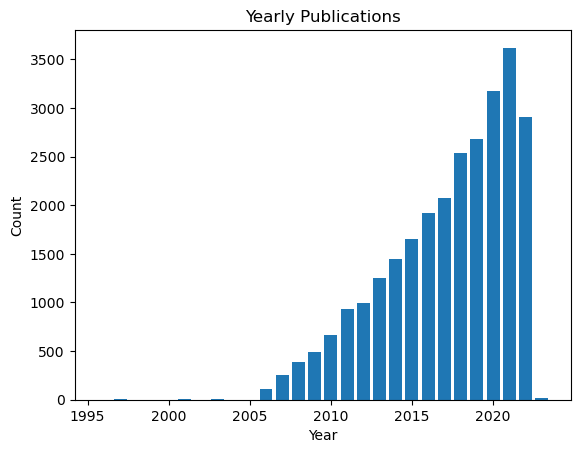

In [51]:
import matplotlib.pyplot as plt

# grouping by 'year' and count occurrences
year_counts = df_maj['year'].value_counts().sort_index()

# create a histogram
plt.bar(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Publications')
plt.show()

In [15]:
df['category'] = df['category'].str.split(';').str[0]
df['category'] = df['category'].astype(str)

In [38]:
# this is if we want to get to 4 broad scientific fields

df_maj['category'] = df_maj['category'].apply(lambda x: 'Natural sciences' if 'biology' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Natural sciences' if 'chemistry' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Natural sciences' if 'physics' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Natural sciences' if 'astronom' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'anthropology' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'history' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'philosophy' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'religion' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Economics' if 'economics' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'geography' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'psychology' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'sociology' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Humanities & social sciences' if 'polit' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Formal sciences' if 'computer' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Formal sciences' if 'mathematics' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Formal sciences' if 'statistics' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Formal sciences' if 'systems' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'agriculture' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'architecture' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'education' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'medicine' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'military' in x.lower() else x)
df_maj['category'] = df_maj['category'].apply(lambda x: 'Professions & applied sciences' if 'Professions & applied sciences' in x else x)

categories = df_maj['category'].value_counts().sort_index()

In [39]:
print(categories)

Acoustics                 2
Allergy                   6
Anatomy & Morphology      3
Anesthesiology            2
Archaeology              19
                       ... 
Virology                  2
Water Resources         444
Women's Studies           8
Zoology                  78
nan                     100
Name: category, Length: 91, dtype: int64


In [44]:
# mapping by a broad scientific field (4 values) 

category_mapping = { "Acoustics" : "Natural sciences",
                    "Allergy": "Professions & applied sciences",
                    "Anatomy & Morphology" : "Natural sciences",
                    "Anesthesiology" : "Professions & applied sciences",
                    "Archaeology" : "Humanities & social sciences",
                    "Architecture" : "Professions & applied sciences",
                    "Area Studies" : "Humanities & social sciences",
                    "Art" : "Humanities & social sciences",
                    "Arts & Humanities - Other Topics" : "Humanities & social sciences",
                    "Behavioral Sciences" : "Humanities & social sciences",
                    "Biodiversity & Conservation" : "Natural sciences",
                    "Cardiovascular System & Cardiology" : "Professions & applied sciences",
                    "Communication" : "Humanities & social sciences",
                    "Construction & Building Technology" : "Professions & applied sciences",
                    "Criminology & Penology" : "Humanities & social sciences",
                    "Cultural Studies" : "Humanities & social sciences",
                    "Demography" : "Humanities & social sciences",
                    "Dermatology" : "Professions & applied sciences",
                    "Development Studies": "Humanities & social sciences",
                    "Economics" : "Humanities & social sciences",
                    "Endocrinology & Metabolism" : "Natural sciences",
                    "Energy & Fuels" : "Professions & applied sciences",
                    "Engineering" : "Professions & applied sciences",
                    "Entomology" : "Natural sciences",
                    "Environmental Sciences & Ecology" : "Professions & applied sciences",
                    "Ethnic Studies" : "Professions & applied sciences",
                    "Family Studies" : "Humanities & social sciences",
                    "Film, Radio & Television" : "Professions & applied sciences",
                    "Fisheries" : "Professions & applied sciences",
                    "Food Science & Technology" : "Professions & applied sciences", 
                    "Forestry" : "Professions & applied sciences",
                    "Genetics & Heredity" : "Natural sciences",
                    "Geology" : "Natural sciences",
                    "Geriatrics & Gerontology" : "Professions & applied sciences",
                    "Government & Law" : "Professions & applied sciences",
                    "Health Care Sciences & Services" : "Professions & applied sciences",
                    "Immunology" : "Professions & applied sciences",
                    "Infectious Diseases" : "Professions & applied sciences",
                    "Information Science & Library Science" : "Formal sciences",
                    "Instruments & Instrumentation" : "Professions & applied sciences",
                    "International Relations" : "Humanities & social sciences",
                    "Materials Science" : "Professions & applied sciences",
                    "Medical Informatics" : "Professions & applied sciences",
                    "Metallurgy & Metallurgical Engineering" : "Professions & applied sciences",
                    "Meteorology & Atmospheric Sciences" : "Natural sciences",
                    "Mining & Mineral Processing" : "Professions & applied sciences",
                    "Mycology" : "Natural sciences",
                    "Neurosciences & Neurology" : "Natural sciences",
                    "Nuclear Science & Technology" : "Professions & applied sciences",
                    "Nursing" : "Professions & applied sciences",
                    "Nutrition & Dietetics" : "Professions & applied sciences",
                    "Obstetrics & Gynecology" : "Professions & applied sciences",
                    "Oceanography" : "Natural sciences",
                    "Oncology" : "Professions & applied sciences",
                    "Operations Research & Management Science" : "Professions & applied sciences",
                    "Ophthalmology" : "Professions & applied sciences",
                    "Paleontology" : "Natural sciences",
                    "Parasitology" : "Natural sciences",
                    "Pediatrics" : "Professions & applied sciences",
                    "Pharmacology & Pharmacy" : "Professions & applied sciences",
                    "Physiology" : "Natural sciences",
                    "Plant Sciences" : "Natural sciences",
                    "Polymer Science" : "Professions & applied sciences",
                    "Psychiatry" : "Professions & applied sciences",
                    "Public Administration " : "Professions & applied sciences",
                    "Public, Environmental & Occupational Health" : "Professions & applied sciences",
                    "Rehabilitation" : "Professions & applied sciences", 
                    "Remote Sensing" : "Natural sciences",
                    "Respiratory System" : "Professions & applied sciences",
                    "Robotics" : "Formal sciences",
                    "Science & Technology - Other Topics" : "Humanities & social sciences",
                    "Social Issues" : "Humanities & social sciences",
                    "Social Sciences - Other Topics" : "Humanities & social sciences",
                    "Social Work" : "Professions & applied sciences",
                    "Sport Sciences" : "Professions & applied sciences",
                    "Substance Abuse" : "Professions & applied sciences",
                    "Telecommunications" :  "Professions & applied sciences",
                    "Thermodynamics" : "Natural sciences",
                    "Toxicology" :  "Professions & applied sciences",
                    "Transportation" :  "Professions & applied sciences",
                    "Urban Studies" :  "Professions & applied sciences",
                    "Urology & Nephrology" :  "Professions & applied sciences",
                    "Veterinary Sciences" :  "Professions & applied sciences",
                    "Virology" : "Natural sciences",
                    "Water Resources" : "Natural sciences",
                    "Women's Studies" : "Humanities & social sciences",
                    "Zoology" : "Natural sciences",
                    "Natural sciences" : "Natural sciences",
                    "Humanities & social sciences" : "Humanities & social sciences",
                    "Formal sciences" : "Formal sciences",
                    "Professions & applied sciences" : "Professions & applied sciences"}

# apply the mapping in a new column
df_maj['field'] = df_maj['category'].map(category_mapping)

In [16]:
# mapping into subfields (32 values)

subfield_list = ["Anthropology", "History", "Linguistics & languages", "Philosophy", "Religion", "The arts", "Economics", "Geography", "Interdisciplinary", "Political science", "Psychology", "Sociology", "Biology", "Chemistry", "Earth sciences", "Physics", "Space sciences", "Computer sciences", "Logic", "Mathematics", "Systems science", "Agriculture", "Architecture & design", "Business", "Divinity", "Education", "Engineering & technology", "Environmental studies & forestry", "Medicine","Law", "Public administration", "Transportation"]

category_mapping2 = {
        "Acoustics": "Physics",
        "Allergy": "Medicine",
        "Anatomy & Morphology": "Biology",
        "Anesthesiology": "Medicine",
        "Archaeology": "Anthropology",
        "Architecture": "Architecture & design",
        "Area Studies": "Interdisciplinary",
        "Art": "The arts",
        "Arts & Humanities - Other Topics": "Interdisciplinary",
        "Behavioral Sciences": "Psychology",
        "Biodiversity & Conservation": "Biology",
        "Cardiovascular System & Cardiology": "Medicine",
        "Communication": "Interdisciplinary",
        "Construction & Building Technology": "Engineering & technology",
        "Criminology & Penology": "Sociology",
        "Cultural Studies": "Interdisciplinary",
        "Demography": "Sociology",
        "Dermatology": "Medicine",
        "Development Studies": "Interdisciplinary",
        "Economics": "Economics",
        "Endocrinology & Metabolism": "Medicine",
        "Energy & Fuels": "Physics",
        "Engineering": "Engineering & technology",
        "Entomology": "Biology",
        "Environmental Sciences & Ecology": "Environmental studies & forestry",
        "Ethnic Studies": "Interdisciplinary",
        "Family Studies": "Sociology",
        "Film, Radio & Television": "The arts",
        "Fisheries": "Biology",
        "Food Science & Technology": "Agriculture",
        "Forestry": "Environmental studies & forestry",
        "Genetics & Heredity": "Biology",
        "Geology": "Earth sciences",
        "Geriatrics & Gerontology": "Medicine",
        "Government & Law": "Political science",
        "Health Care Sciences & Services": "Medicine",
        "Immunology": "Biology",
        "Infectious Diseases": "Medicine",
        "Information Science & Library Science": "Computer sciences",
        "Instruments & Instrumentation": "Physics",
        "International Relations": "Political science",
        "Materials Science": "Engineering & technology",
        "Medical Informatics": "Computer sciences",
        "Metallurgy & Metallurgical Engineering": "Engineering & technology",
        "Meteorology & Atmospheric Sciences": "Earth sciences",
        "Mining & Mineral Processing": "Engineering & technology",
        "Mycology": "Biology",
        "Neurosciences & Neurology": "Biology",
        "Nuclear Science & Technology": "Physics",
        "Nursing": "Medicine",
        "Nutrition & Dietetics": "Medicine",
        "Obstetrics & Gynecology": "Medicine",
        "Oceanography": "Earth sciences",
        "Oncology": "Medicine",
        "Operations Research & Management Science": "Business",
        "Ophthalmology": "Medicine",
        "Paleontology": "Biology",
        "Parasitology": "Biology",
        "Pediatrics": "Medicine",
        "Pharmacology & Pharmacy": "Medicine",
        "Physiology": "Biology",
        "Plant Sciences": "Biology",
        "Polymer Science": "Chemistry",
        "Psychiatry": "Medicine",
        "Public Administration": "Public administration",
        "Public, Environmental & Occupational Health": "Medicine",
        "Rehabilitation": "Medicine",
        "Remote Sensing": "Earth sciences",
        "Respiratory System": "Medicine",
        "Robotics": "Engineering & technology",
        "Science & Technology - Other Topics": "Interdisciplinary",
        "Social Issues": "Sociology",
        "Social Sciences - Other Topics": "Interdisciplinary",
        "Social Work": "Sociology",
        "Sport Sciences": "Medicine",
        "Substance Abuse": "Medicine",
        "Telecommunications": "Engineering & technology",
        "Thermodynamics": "Physics",
        "Toxicology": "Medicine",
        "Transportation": "Transportation",
        "Urban Studies": "Geography",
        "Urology & Nephrology": "Medicine",
        "Veterinary Sciences": "Agriculture",
        "Virology": "Biology",
        "Water Resources": "Geography",
        "Women's Studies": "Sociology",
        "Zoology": "Biology",
        "Business & Economics" : "Economics",
        "Geography": "Geography",
        "Agriculture": "Agriculture",
        "Chemistry": "Chemistry",
        "Marine & Freshwater Biology": "Biology",
        "Life Sciences & Biomedicine - Other Topics": "Biology",
        "Microbiology": "Biology",
        "Physical Geography": "Geography",
        "Biotechnology & Applied Microbiology": "Biology",
        "Biochemistry & Molecular Biology": "Biology",
        "Anthropology": "Anthropology",
        "Cell Biology": "Biology",
        "Education & Educational Research": "Education",
        "Computer Science": "Computer sciences",
        "Evolutionary Biology": "Biology",
        "General & Internal Medicine": "Medicine",
        "History & Philosophy of Science": "History",
        "Sociology": "Sociology",
        "Automation & Control Systems": "Engineering & technology",
        "Mathematics": "Mathematics",
        "Geochemistry & Geophysics": "Earth sciences",
        "Psychology": "Psychology",
        "Physics": "Physics",
        "Biophysics": "Physics",
        "History": "History",
        "Emergency Medicine": "Medicine",
        "Philosophy": "Philosophy",
        "Mathematical & Computational Biology": "Biology",
        "Tropical Medicine": "Medicine",
        "Astronomy & Astrophysics": "Physics",
        "nan": "Unknown",
        "Reproductive Biology": "Biology",
        "Developmental Biology": "Biology",
        "Religion": "Religion",
        "Electrochemistry": "Chemistry",
    }

# apply the mapping in a new column
df['subfield'] = df['category'].map(category_mapping2)

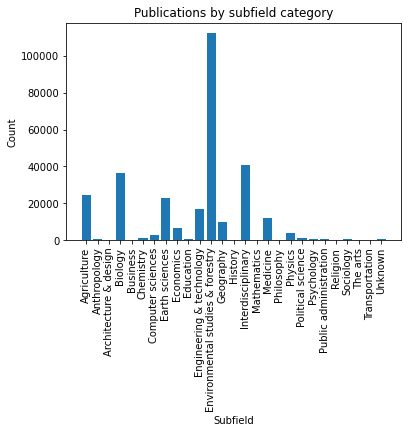

In [18]:
import matplotlib.pyplot as plt

# group by 'year' and count occurrences
subfield_counts = df['subfield'].value_counts().sort_index()

# create a histogram
plt.bar(subfield_counts.index, subfield_counts.values)
plt.xlabel('Subfield')
plt.ylabel('Count')
plt.title('Publications by subfield category')
plt.xticks(subfield_counts.index, rotation='vertical')

plt.show()

In [70]:
df_maj.to_csv("data/df_maj_1408.csv")

# introduce 'unknown' as a factor level for gender - thus keeping all the documents in the dataset 

In [56]:
def calculate_majority_female(prob_string):
    try:
        probabilities = [float(x) for x in prob_string.split(';')]
        return sum(probabilities) / len(probabilities)
    except (ValueError, ZeroDivisionError):
        return np.nan

df_maj['majority_female'] = df_maj['author_female'].apply(calculate_majority_female)

In [59]:
df_maj['majority_female'].value_counts()

27712

In [67]:
df_maj['majority_female_binary'] = np.where(df_maj['majority_female'] > 0.5, 1,
                                     np.where(df_maj['majority_female'] < 0.5, 0, np.nan))

In [69]:
df_maj['majority_female_binary'].value_counts()

# 27 712 all unambiguous gender predictions for the full group
# 6 338 majority female (22,87%) 
# 17 169 majotiy male (61,96%)
# 4 205 with gender parity (15,17%)

# save output at this stage
df_maj.to_csv("data/df_maj_1008.csv")

In [4]:
df_maj= pd.read_csv("data/df_maj_1008.csv")

In [ ]:
### df_first and df_last ### 

In [12]:
# drop rows with missing author name values
# we are already taking the "full name" field in here, but some of them still are initials
df = df[df['author_name'].notna()]
unique_count_id = df['id'].nunique()
print(unique_count_id)
# N = 49,422 after empty records

49422


In [13]:
df = df[df['id'].notna()]
unique_count_id = df['id'].nunique()
print(unique_count_id)
# 49,422

49422


In [20]:
df['author_name'] = df['author_name'].astype(str)
df['institution'] = df['institution'].astype(str)
df['position'] = df['position'].astype(str)
# here, we create a dataframe for first_author_gender and another one for last_author_gender
df_first = pd.DataFrame()
df_last = pd.DataFrame()
# group by id and aggregate the other columns
df_first = df.groupby('id').agg({'author_name': lambda x: '; '.join(x), 
                               'institution': lambda x: '; '.join(x),
                               'position': lambda x: '; '.join(x),
                               'abstract': 'first',
                               'year': 'first',
                               'publisher': 'first',
                               'category': 'first',
                              'title': 'first',
                                'subfield': 'first'})
df_last = df.groupby('id').agg({'author_name': lambda x: '; '.join(x), 
                               'institution': lambda x: '; '.join(x),
                               'position': lambda x: '; '.join(x),
                               'abstract': 'first',
                               'year': 'first',
                               'publisher': 'first',
                               'category': 'first',
                              'title': 'first',
                               'subfield': 'first'})

# rename the aggregated column and reset the index
df_first = df_first.rename(columns={'author_name': 'authors_names'}).reset_index()
df_last = df_last.rename(columns={'author_name': 'authors_names'}).reset_index()

In [22]:
# exclude economics papers from these variables as author order is alphabetical
df_first = df_first[df_first['subfield']!='Economics']
df_last = df_last[df_last['subfield']!='Economics']

In [25]:
df_first.shape[0]
# 47,700
df_last.shape[0]
# 47,700

47700

In [26]:
# clean up assigned author positions
def process_positions(position_string):
    positions_list = [float(number) for number in position_string.split(";")]
    if any(number == 0.0 for number in positions_list):
        positions_list = [str(number + 1) for number in positions_list]
    else:
        positions_list = [str(number) for number in positions_list]
    return ';'.join(positions_list)

df_first['position'] = df_first['position'].apply(process_positions)

In [35]:
df_last['position'] = df_last['position'].apply(process_positions)
# get rid of single-authored papers for this dataset
df_last = df_last[df_last['position'].apply(lambda x: len(x.split(';')) > 1)]

In [ ]:
display(df_last)
#45,685

In [37]:
df_first["first_author"] = np.nan
df_last["last_author"] = np.nan

In [42]:
# let's look at the single authored papers
df_single = df.groupby('id').agg({'author_name': lambda x: '; '.join(x), 
                               'institution': lambda x: '; '.join(x),
                               'position': lambda x: '; '.join(x),
                               'abstract': 'first',
                               'year': 'first',
                               'publisher': 'first',
                               'category': 'first',
                              'title': 'first',
                                'subfield': 'first'})
df_single = df_single[df_single['position'].str.split(';').apply(len)==1]

In [43]:
display(df_single)
# 2,124 

,author_name,institution,position,abstract,year,publisher,category,title,subfield
id,,,,,,,,,
880,"James, Philip A. S.","['Univ York, Dept Environm, York YO10 5DD, N Y...",1.0,"As part of ongoing economic reforms, the Ugand...",2010.0,WILEY,Development Studies,Using Farmers' Preferences to Assess Developme...,Interdisciplinary
1173,"Urban, Frauke","Univ Groningen, NL-9700 AB Groningen, Netherla...",1.0,Climate change adaptation and mitigation needs...,2010.0,WILEY,Area Studies,The MDGs and Beyond: Can Low Carbon Developmen...,Interdisciplinary
2889,"Botella, Alberic","Univ Ottawa, Inst Environm, Dept Sci Terre, Ot...",1.0,"Over the coming decades, sea-level rise will i...",2016.0,TAYLOR & FRANCIS LTD,Water Resources,Regional projections of Sea-level Rise in Fren...,Geography
6282,"Priyadarshan, P. M.","Rubber Res Inst India Erstwhile, 9 Neelanjali,...",1.0,Hevea brasiliensis (Willd. Ex. A. de. Juss. Mu...,2017.0,SPRINGER HEIDELBERG,Forestry,Refinements to Hevea rubber breeding,Environmental studies & forestry
8366,"Muller, Scott A.","CODESTA, Panama City, Panama.",1.0,Climate change is one of the defining issues f...,2011.0,WILEY,Dermatology,"Climate change, dermatology and ecosystem serv...",Medicine
...,...,...,...,...,...,...,...,...,...
5415392,"Stephens, Jennie C.","Northeastern Univ, Sch Publ Policy & Urban Aff...",1.0,Purpose of Review This review explores how mor...,None,SPRINGER HEIDELBERG,Meteorology & Atmospheric Sciences,Beyond Climate Isolationism: a Necessary Shift...,Earth sciences
5435294,"Petrucci, Olga","CNR IRPI Res Inst Geohydrol Protect, Via Cavou...",1.0,Landslides triggered by rainfall kill people w...,2022.0,MDPI,Science & Technology - Other Topics,Landslide Fatality Occurrence: A Systematic Re...,Interdisciplinary
5437279,[Anonymous],[''],1.0,"Carbon dioxide reductions are key, but the IPC...",2021.0,NATURE PORTFOLIO,Science & Technology - Other Topics,Control methane to slow global warming - fast,Interdisciplinary


In [45]:
df_last = df_last[~df_last['id'].isin(df_single.index)].reset_index(drop=True)

In [48]:
display(df_last)
# 47,700 df_first
# 45,685 df_last

,id,authors_names,institution,position,abstract,year,publisher,category,title,subfield,last_author
0,20,"Erasmus, BFN; Van Jaarsveld, AS; Chown, SL; Ks...",nan; nan; nan; nan; nan; nan; nan; nan; nan; nan,1.0;2.0;3.0;4.0;5.0;4.0;3.0;2.0;6.0;5.0,The responsiveness of South African fauna to c...,2002.0,WILEY,Biodiversity & Conservation,Vulnerability of South African animal taxa to ...,Biology,NaN
1,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...","Purdue Univ, Dept Polit Sci, W Lafayette, IN 4...",5.0;7.0;6.0;3.0;10.0;1.0;5.0;6.0;7.0;8.0;2.0;4...,We provide a synthesis of what regional scient...,2013.0,RESILIENCE ALLIANCE,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,Environmental studies & forestry,NaN
2,157,"Thompson, John; Scoones, Ian; Scoones, Ian","Univ Sussex, STEPS Ctr, Brighton BN1 9RE, E Su...",1.0;1.0;2.0,The 'modernist' project that has come to domin...,2009.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,Environmental studies & forestry,NaN
3,195,"Beermann, Marina; Beermann, Marina","['Carl von Ossietzky Univ Oldenburg, Inst Busi...",2.0;1.0,"Within modern society, business organizations ...",2011.0,ELSEVIER SCI LTD,Science & Technology - Other Topics,Linking corporate climate adaptation strategie...,Interdisciplinary,NaN
4,222,"Lenzholzer, Sanda; Lenzholzer, Sanda","nan; ['Wageningen Univ, NL-6700 AA Wageningen,...",1.0;2.0,Human thermal comfort in urban outdoor places ...,2012.0,ELSEVIER SCIENCE BV,Engineering,Research and design for thermal comfort in Dut...,Engineering & technology,NaN
...,...,...,...,...,...,...,...,...,...,...,...
45680,5495916,"Thomas, T.; Nayak, P. C.; Ventakesh, B.","Natl Inst Hydrol, WALMI Campus, Bhopal 462042,...",1.0;2.0;3.0,Drought is an extreme event and its frequency ...,2022.0,SPRINGER,Environmental Sciences & Ecology,Integrated assessment of drought vulnerability...,Environmental studies & forestry,NaN
45681,5496103,"Boakes, Zach; Boakes, Zach; Hall, Alice E.; Am...","Bournemouth Univ, Ctr Ecol Environm & Sustaina...",1.0;1.0;2.0;3.0;4.0;5.0;6.0;7.0;8.0,"Bali, Indonesia sits within the coral triangle...",2022.0,ELSEVIER GMBH,Biodiversity & Conservation,Coral reef conservation in Bali in light of in...,Biology,NaN
45682,5496272,"Sadiq, Muhammad; Wen, Fenghua; Wen, Fenghua; B...","Cent South Univ, Sch Business, Changsha 410083...",1.0;2.0;2.0;3.0;4.0,Global energy systems must be restructured to ...,2022.0,ELSEVIER SCI LTD,Science & Technology - Other Topics,Does nuclear energy consumption contribute to ...,Interdisciplinary,NaN
45683,5541192,"Wen, Ying; Wen, Ying; Wen, Ying; Zhang, Gaosen...","Chinese Acad Sci, Northwest Inst Ecoenvironm &...",1.0;1.0;1.0;2.0;2.0;3.0;3.0;4.0;4.0;4.0;5.0;5....,The harsh climatic conditions of deserts may l...,2022.0,MDPI,Microbiology,Genomic Investigation of Desert Streptomyces h...,Biology,NaN


In [49]:
# now, let's write the first and last author names in the corresponding columns
def process_first(row):
    positions_list = [float(number) for number in row['position'].split(";")]
    try:
        index_of_1 = positions_list.index(1)
        row['first_author'] = row['authors_names'].split(';')[index_of_1]
        row['first_institution'] = row['institution'].split(';')[index_of_1]
        return row
    except ValueError:
        return None

df_first = df_first.apply(process_first, axis=1).dropna()
    
def process_last(row):
    positions_list = [float(number) for number in row['position'].split(";")]
    try:
        row['last_author'] = row['authors_names'].split(';')[positions_list.index(max(positions_list))]
        row['last_institution'] = row['institution'].split(';')[positions_list.index(max(positions_list))]
        return row
    except ValueError:
        return None
    
df_last = df_last.apply(process_last, axis=1).dropna()

In [52]:
# 46,677 df_first
# 44,780 df_last

In [56]:
# df_single = df_single.drop('first_author', axis=1)
def extract_first_name(authors_names):
    names = authors_names.split(",")
    if len(names) > 1:
        return names[1].strip()
    return None

df_single['first_name'] = df_single['author_name'].apply(lambda x: extract_first_name(x))
df_single.dropna(subset=['first_name'], inplace=True)

# replace hyphens with spaces
df_single['name'] = df_single['first_name'].str.replace('-', ' ', regex=False)

# keep only the part that is not initials
df_single['name'] = df_single['name'].apply(extract_non_initials)

# get rid of other special symbols
special = ['(', ')']
for x in special:
    df_single['name'] = df_single['name'].str.replace(re.escape(x), '', regex=False)
df_single.dropna(subset=['first_name'], inplace=True)

df_single.shape[0]
# 2,109

2109

In [58]:
display(df_last)

,id,authors_names,institution,position,abstract,year,publisher,category,title,subfield,last_author,last_institution
0,20,"Erasmus, BFN; Van Jaarsveld, AS; Chown, SL; Ks...",nan; nan; nan; nan; nan; nan; nan; nan; nan; nan,1.0;2.0;3.0;4.0;5.0;4.0;3.0;2.0;6.0;5.0,The responsiveness of South African fauna to c...,2002.0,WILEY,Biodiversity & Conservation,Vulnerability of South African animal taxa to ...,Biology,"Wessels, KJ",nan
1,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...","Purdue Univ, Dept Polit Sci, W Lafayette, IN 4...",5.0;7.0;6.0;3.0;10.0;1.0;5.0;6.0;7.0;8.0;2.0;4...,We provide a synthesis of what regional scient...,2013.0,RESILIENCE ALLIANCE,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,Environmental studies & forestry,"Annegarn, Harold","Univ Johannesburg, Dept Geog Environm Managem..."
2,157,"Thompson, John; Scoones, Ian; Scoones, Ian","Univ Sussex, STEPS Ctr, Brighton BN1 9RE, E Su...",1.0;1.0;2.0,The 'modernist' project that has come to domin...,2009.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,Environmental studies & forestry,"Scoones, Ian",nan
3,195,"Beermann, Marina; Beermann, Marina","['Carl von Ossietzky Univ Oldenburg, Inst Busi...",2.0;1.0,"Within modern society, business organizations ...",2011.0,ELSEVIER SCI LTD,Science & Technology - Other Topics,Linking corporate climate adaptation strategie...,Interdisciplinary,"Beermann, Marina","['Carl von Ossietzky Univ Oldenburg, Inst Busi..."
4,222,"Lenzholzer, Sanda; Lenzholzer, Sanda","nan; ['Wageningen Univ, NL-6700 AA Wageningen,...",1.0;2.0,Human thermal comfort in urban outdoor places ...,2012.0,ELSEVIER SCIENCE BV,Engineering,Research and design for thermal comfort in Dut...,Engineering & technology,"Lenzholzer, Sanda","['Wageningen Univ, NL-6700 AA Wageningen, Net..."
...,...,...,...,...,...,...,...,...,...,...,...,...
45680,5495916,"Thomas, T.; Nayak, P. C.; Ventakesh, B.","Natl Inst Hydrol, WALMI Campus, Bhopal 462042,...",1.0;2.0;3.0,Drought is an extreme event and its frequency ...,2022.0,SPRINGER,Environmental Sciences & Ecology,Integrated assessment of drought vulnerability...,Environmental studies & forestry,"Ventakesh, B.","Natl Inst Hydrol, Belgaum 590019, Karnataka, ..."
45681,5496103,"Boakes, Zach; Boakes, Zach; Hall, Alice E.; Am...","Bournemouth Univ, Ctr Ecol Environm & Sustaina...",1.0;1.0;2.0;3.0;4.0;5.0;6.0;7.0;8.0,"Bali, Indonesia sits within the coral triangle...",2022.0,ELSEVIER GMBH,Biodiversity & Conservation,Coral reef conservation in Bali in light of in...,Biology,"Stafford, Richard","Bournemouth Univ, Fac Sci & Technol, Dept Lif..."
45682,5496272,"Sadiq, Muhammad; Wen, Fenghua; Wen, Fenghua; B...","Cent South Univ, Sch Business, Changsha 410083...",1.0;2.0;2.0;3.0;4.0,Global energy systems must be restructured to ...,2022.0,ELSEVIER SCI LTD,Science & Technology - Other Topics,Does nuclear energy consumption contribute to ...,Interdisciplinary,"Amin, Azka","Sukkur IBA Univ, Dept Business Adm, Sukkur, P..."
45683,5541192,"Wen, Ying; Wen, Ying; Wen, Ying; Zhang, Gaosen...","Chinese Acad Sci, Northwest Inst Ecoenvironm &...",1.0;1.0;1.0;2.0;2.0;3.0;3.0;4.0;4.0;4.0;5.0;5....,The harsh climatic conditions of deserts may l...,2022.0,MDPI,Microbiology,Genomic Investigation of Desert Streptomyces h...,Biology,"Liu, Guangxiu","Chinese Acad Sci, Northwest Inst Ecoenvironm ..."


In [ ]:
"""final_df = pd.read_csv('data/final.csv', usecols = ['id','keywords'])
final_df = final_df.drop(index = 0)
df_first = pd.merge(df_first,final_df,on='id',how='left')
df_last = pd.merge(df_last,final_df,on='id',how='left')
df_maj = pd.merge(df_maj,final_df,on='id',how='left')"""

In [59]:
df_first['first_name'] = df_first['first_author'].apply(lambda x: extract_first_name(x))
df_first.dropna(subset=['first_name'], inplace=True)
df_last['first_name'] = df_last['last_author'].apply(lambda x: extract_first_name(x))
df_last.dropna(subset=['first_name'], inplace=True)

In [62]:
df_first.shape[0]
# 46,265
df_last.shape[0]
#44,474

44474

In [63]:
# replace hyphens with spaces
df_first['name'] = df_first['first_name'].str.replace('-', ' ', regex=False)

# keep only the part that is not initials
df_first['name'] = df_first['name'].apply(extract_non_initials)

# get rid of other special symbols
special = ['(', ')']
for x in special:
    df_first['name'] = df_first['name'].str.replace(re.escape(x), '', regex=False)
df_first.dropna(subset=['name'], inplace=True)

In [64]:
df_first.shape[0]
# 41,637

41637

In [65]:
# replace hyphens with spaces
df_last['name'] = df_last['first_name'].str.replace('-', ' ', regex=False)

# keep only the part that is not initials
df_last['name'] = df_last['name'].apply(extract_non_initials)

# get rid of other special symbols
special = ['(', ')']
for x in special:
    df_last['name'] = df_last['name'].str.replace(re.escape(x), '', regex=False)
df_last.dropna(subset=['name'], inplace=True)

In [66]:
df_last.shape[0]
#39,692

39692

In [67]:
# add gender
df_first = pd.merge(df_first, df_gender_m[['name','prob_female']], how = 'left', on = 'name')
df_last = pd.merge(df_last, df_gender_m[['name','prob_female']], how = 'left', on = 'name')
df_single = pd.merge(df_single, df_gender_m[['name','prob_female']], how = 'left', on = 'name')

In [68]:
df_first['prob_female'].value_counts().sum()
#37,546

37546

In [74]:
df_first['first_author_female'] = np.where(df_first['prob_female'] >= 0.75, 1,
                                     np.where(df_first['prob_female'] <= 0.25, 0, np.nan))

In [76]:
df_first['first_author_female'].value_counts()
print(df_first['first_author_female'].value_counts().sum()/df_first['id'].value_counts().sum())
# 37,546
# 21,626 M 13,727 F
# 84,91% from all clean dataset

0.8490765424982588


In [73]:
df_last['prob_female'].value_counts().sum()
# 36,192

36192

In [77]:
df_last['last_author_female'] = np.where(df_last['prob_female'] >= 0.75, 1,
                                     np.where(df_last['prob_female'] <= 0.25, 0, np.nan))

In [79]:
df_last['last_author_female'].value_counts()
#print(df_last['last_author_female'].value_counts().sum()/df_last['id'].value_counts().sum())
# 36,192
# 24,280 M 10,050 F
# 86,49% from all clean dataset

0.0    24280
1.0    10050
Name: last_author_female, dtype: int64

In [81]:
df_single['prob_female'].value_counts().sum()
# 1834

1834

In [82]:
df_single['author_female'] = np.where(df_single['prob_female'] >= 0.75, 1,
                                     np.where(df_single['prob_female'] <= 0.25, 0, np.nan))

In [88]:
df_single['author_female'].value_counts()
#print(df_single['author_female'].value_counts().sum()/len(df_single.index))
# 1,834
# 1,105 M 625 F
# 82,03% from all clean dataset

0.0    1105
1.0     625
Name: author_female, dtype: int64

In [89]:
df_first.to_csv("data/df_first_1608.csv")
df_last.to_csv("data/df_last_1608.csv")
df_single.to_csv("data/df_single_1608.csv")

In [ ]:
# add gii_quartile
def extract_country(institution):
    try:
        parts = institution.split(',')
        #for part in reversed(parts):
        try:
            country = pycountry.countries.search_fuzzy(parts[-1].strip().replace('.','').replace('[','').replace(']','').replace("''","").replace("'",''))[0].name
            return country
        except LookupError:
            try: 
                lastpart = parts[-1].split(' ')[-1]
                country = pycountry.countries.search_fuzzy(lastpart.strip().replace('.','').replace('[','').replace(']','').replace("''","").replace("'",''))[0].name
                return country
            except LookupError:
                return None
    except AttributeError:
        return None
# apply the extract_country function to the 'first_institution' column to create the 'first_country' column
df_first['country'] = df_first['first_institution'].apply(lambda x: extract_country(x))
df_last['country'] = df_last['last_institution'].apply(lambda x: extract_country(x))

In [75]:
gii_hdi_data = pd.read_excel("Users/dianadanilenko/Desktop/personal/master_thesis/methods/python_scripts/data/gender_inequality_index.xlsx")
gii_hdi_data['gii_quartile'] = pd.qcut(gii_hdi_data['gender inequality index'], q=4, labels = [1,2,3,4])
# df_first = df_first.rename(columns={'first_country':'country'})
# df_last = df_last.rename(columns={'last_country':'country'})
# df_maj = pd.merge(df_maj,df_last[['id','last_institution','country']],on='id',how='left')

In [162]:
def country_clean(row):
    try:
        if ('Thailand' not in row["first_institution"]) and ('Thailand' in row["country"]):
            return ""
    except TypeError:
        return ""
    
    if pd.isna(row["country"]) and ('United Kingdom' not in row["first_institution"]):
        institution_str = str(row["first_institution"])
        if ('England' in institution_str) and ('New England' not in institution_str):
            return "United Kingdom"
        elif ('Wales' in institution_str) and ('New Wales' not in institution_str):
            return "United Kingdom"
        elif 'Scotland' in institution_str:
            return "United Kingdom"
        elif 'Northern Ireland' in institution_str:
            return "United Kingdom"
    return row["country"]

df_first["country"] = df_first.apply(country_clean, axis=1)

In [3]:
dataset = pd.read_csv("/Users/dianadanilenko/Desktop/personal/master_thesis/methods/python_scripts/data/dataset_articles.csv")

In [4]:
dataset['author_keywords'] = dataset['author_keywords'].astype(str)
dataset['keywords_plus'] = dataset['keywords_plus'].astype(str)
dataset['keywords'] = dataset.apply(lambda x: ';'.join([x['author_keywords'], x['keywords_plus']]), axis=1)

# match with gii_quantile and gii_index data on 'country'

In [145]:
df_last_1804 = pd.merge(df_last, gii_hdi_data[['country','gii_quartile','gender inequality index']], on='country',how='left')

In [134]:
df_first_1804 = pd.merge(df_first[['id','authors_names','name','abstract','year','category','title','first_author_female','first_institution','country']], gii_hdi_data[['country','gii_quartile','gender inequality index']], on='country',how='left')

# match with journal and keywords on 'title'

In [7]:
df = pd.merge(df,dataset[['title','journal','keywords']],on='title',how='left')

# after all the merges we need to deduplicate the dfs on 'id' and then record the numbers and descriptives

# assign journal impact factor with the package impact-factor

In [27]:
import impact_factor
from impact_factor.core import Factor

fa = Factor()

def journalfactor(journal):
    try:
        return fa.search(str(journal).strip())[0]['jcr'], fa.search(str(journal).strip())[0]['factor']
    except IndexError:
        return None

In [28]:
df_full['journal_impact'] = df_full['journal'].apply(journalfactor)

In [29]:
def get_quartile(a):
    try:
        return str(a).split(',')[0].replace('(','').replace("'","").replace("Q","")
    except IndexError:
        return None
def get_factor(x):
    try:
        return str(x).split(',')[1].replace(')','')
    except IndexError:
        return None

In [30]:
# do this on the full dataset
df_full['impact_quartile'] = df_full['journal_impact'].apply(get_quartile)
df_full['impact_factor'] = df_full['journal_impact'].apply(get_factor)

In [31]:
df_full.to_csv("data/df_full.csv")

In [32]:
df_full['impact_factor'].value_counts()

 3.889     1617
 5.174      915
 10.753     790
 3.53       765
 6.424      752
           ... 
 5.43         1
 3.348        1
 1.229        1
 2.005        1
 1.679        1
Name: impact_factor, Length: 2310, dtype: int64

# save the outputs and run STM 
# run and explore estimateEffect() with different equations 

In [91]:
df_first_1804 = pd.read_csv("/Users/dianadanilenko/Desktop/personal/master_thesis/methods/python_scripts/data/df_first_1804.csv")
df_last_1804 = pd.read_csv("/Users/dianadanilenko/Desktop/personal/master_thesis/methods/python_scripts/data/df_last_1804.csv")

In [166]:
df_maj_1804 = pd.read_csv("/Users/dianadanilenko/Desktop/personal/master_thesis/methods/python_scripts/data/df_maj_1804.csv")

In [98]:
df_last_1804.drop("Unnamed: 0.1", axis=1,inplace=True)

In [168]:
display(df_maj_1804)
#['id','abstract', 'year','title','country','gii_quartile','gii','keywords','impact_quartile']

,Unnamed: 0,Unnamed: 0.1,id,author_name,name,abstract,year,category,title,majority_female_binary,majority_female,last_institution,country,gii_quartile,gii,journal,keywords,journal_impact,impact_quartile,impact_factor
0,0,0,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...",Elizabeth; Tatiana; Jean; Mercedes; Harold; My...,We provide a synthesis of what regional scient...,2013.0,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,NaN,NaN,"Univ Johannesburg, Dept Geog Environm Managem...",South Africa,3.0,0.405,ECOLOGY AND SOCIETY,Africa; capacity building; global change; Lati...,"('Q1', 4.653)",1,4.653
1,1,1,157,"Thompson, John; Scoones, Ian",John; Ian,The 'modernist' project that has come to domin...,2009.0,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,0.0,0.00,nan,NaN,NaN,NaN,ENVIRONMENTAL SCIENCE & POLICY,Agriculture; Agroecology; Agri-food system; Su...,"('Q1', 6.424)",1,6.424
2,2,2,195,"Beermann, Marina",Marina,"Within modern society, business organizations ...",2011.0,Science & Technology - Other Topics; Engineeri...,Linking corporate climate adaptation strategie...,1.0,1.00,"['Carl von Ossietzky Univ Oldenburg, Inst Busi...",Germany,1.0,0.073,JOURNAL OF CLEANER PRODUCTION,Climate change; Food industry; Adaptation/miti...,"('Q1', 11.072)",1,11.072
3,3,3,222,"Lenzholzer, Sanda",Sanda,Human thermal comfort in urban outdoor places ...,2012.0,Engineering; Environmental Sciences & Ecology,Research and design for thermal comfort in Dut...,1.0,1.00,"['Wageningen Univ, NL-6700 AA Wageningen, Net...",Netherlands,1.0,0.025,RESOURCES CONSERVATION AND RECYCLING,Urban microclimate; Thermal comfort; Perceptio...,"('Q1', 13.716)",1,13.716
4,4,4,278,"Pratchett, Morgan S.; Hobday, Alistair J.; Gil...",Morgan; Alistair; Bronwyn; John,Anthropogenic climate change is already appare...,2011.0,Fisheries; Marine & Freshwater Biology; Oceano...,Climate change and Australian marine and fresh...,NaN,NaN,"Univ Adelaide, So Seas Ecol Labs, Sch Earth &...",Australia,1.0,0.073,MARINE AND FRESHWATER RESEARCH,adaptation; climate; estuaries; impacts; Indo ...,"('Q2', 2.358)",2,2.358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41152,42974,42923,5493239,"Sinha, Bhaskar; Bisaria, Jigyasa; Thomas, Thom...",Bhaskar; Jigyasa; Thomas; Pankaj; Manisha,Understanding synergies and trade-offs between...,NaN,Environmental Sciences & Ecology; Water Resources,Understanding synergies and tradeoffs between ...,NaN,NaN,"Indian Inst Forest Management, Bhopal, India.",India,3.0,0.490,WILEY INTERDISCIPLINARY REVIEWS-WATER,adaptive strategies; forest management; India;...,"('Q1', 7.428)",1,7.428
41153,42975,42924,5493590,"Wu, Zhen; Huang, Xianjin; Chen, Ruishan; Mao, ...",Zhen; Xianjin; Ruishan; Xiyan; Xinxian,The rapid economic development has highlighted...,2022.0,Environmental Sciences & Ecology,The United States and China on the paths and p...,NaN,NaN,"Nanjing Univ, Sch Geog & Ocean Sci, Xianlin A...",China,2.0,0.192,JOURNAL OF ENVIRONMENTAL MANAGEMENT,Carbon neutrality; Carbon emission reduction p...,"('Q1', 8.91)",1,8.910
41154,42976,42925,5496272,"Sadiq, Muhammad; Wen, Fenghua; Bashir, Muhamma...",Muhammad; Fenghua; Muhammad; Azka,Global energy systems must be restructured to ...,2022.0,Science & Technology - Other Topics; Engineeri...,Does nuclear energy consumption contribute to ...,0.0,0.50,"Sukkur IBA Univ, Dept Business Adm, Sukkur, P...",Pakistan,4.0,0.534,JOURNAL OF CLEANER PRODUCTION,Human development index; Nuclear energy; Publi...,"('Q1', 11.072)",1,11.072
41155,42977,42926,5541192,"Wen, Ying; Zhang, Gaosen; Bahadur, Ali; Xu, Ye...",Ying; Gaosen; Ali; Yeteng; Yang; Mao; Wei; Tuo...,The harsh climatic conditions of deserts may l...,2022.0,Microbiology,Genomic Investigation of Desert Streptomyces h...,NaN,NaN,"Chinese Acad Sci, Northwest Inst Ecoenvironm ...",China,2.0,0.192,MICROORGANISMS,Streptomyces genome; bioactive; biosynthetic g...,"('Q2', 4.

In [100]:
display(df_last)
#['id','last_author_female']

,id,authors_names,institution,position,abstract,year,publisher,category,title,subfield,last_author,last_institution,first_name,name,prob_female,last_author_female
0,20,"Erasmus, BFN; Van Jaarsveld, AS; Chown, SL; Ks...",nan; nan; nan; nan; nan; nan; nan; nan; nan; nan,1.0;2.0;3.0;4.0;5.0;4.0;3.0;2.0;6.0;5.0,The responsiveness of South African fauna to c...,2002.0,WILEY,Biodiversity & Conservation,Vulnerability of South African animal taxa to ...,Biology,"Wessels, KJ",nan,KJ,KJ,NaN,NaN
1,108,"McNie, Elizabeth; Schor, Tatiana; Ometto, Jean...","Purdue Univ, Dept Polit Sci, W Lafayette, IN 4...",5.0;7.0;6.0;3.0;10.0;1.0;5.0;6.0;7.0;8.0;2.0;4...,We provide a synthesis of what regional scient...,2013.0,RESILIENCE ALLIANCE,Environmental Sciences & Ecology,The Contributions of Regional Knowledge Networ...,Environmental studies & forestry,"Annegarn, Harold","Univ Johannesburg, Dept Geog Environm Managem...",Harold,Harold,0.0,0.0
2,157,"Thompson, John; Scoones, Ian; Scoones, Ian","Univ Sussex, STEPS Ctr, Brighton BN1 9RE, E Su...",1.0;1.0;2.0,The 'modernist' project that has come to domin...,2009.0,ELSEVIER SCI LTD,Environmental Sciences & Ecology,Addressing the dynamics of agri-food systems: ...,Environmental studies & forestry,"Scoones, Ian",nan,Ian,Ian,0.0,0.0
3,195,"Beermann, Marina; Beermann, Marina","['Carl von Ossietzky Univ Oldenburg, Inst Busi...",2.0;1.0,"Within modern society, business organizations ...",2011.0,ELSEVIER SCI LTD,Science & Technology - Other Topics,Linking corporate climate adaptation strategie...,Interdisciplinary,"Beermann, Marina","['Carl von Ossietzky Univ Oldenburg, Inst Busi...",Marina,Marina,1.0,1.0
4,222,"Lenzholzer, Sanda; Lenzholzer, Sanda","nan; ['Wageningen Univ, NL-6700 AA Wageningen,...",1.0;2.0,Human thermal comfort in urban outdoor places ...,2012.0,ELSEVIER SCIENCE BV,Engineering,Research and design for thermal comfort in Dut...,Engineering & technology,"Lenzholzer, Sanda","['Wageningen Univ, NL-6700 AA Wageningen, Net...",Sanda,Sanda,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39687,5495065,"Johnson, Cheryl A.; Johnson, Cheryl A.; Drever...","Environm & Climate Change Canada, Sci & Techno...",1.0;1.0;2.0;3.0;5.0;4.0;5.0,Boreal caribou require large areas of undistur...,2022.0,NATURE PORTFOLIO,Science & Technology - Other Topics,Protecting boreal caribou habitat can help con...,Interdisciplinary,"Martin, Amanda E.","Environm & Climate Change Canada, Sci & Techn...",Amanda E.,Amanda,1.0,1.0
39688,5496103,"Boakes, Zach; Boakes, Zach; Hall, Alice E.; Am...","Bournemouth Univ, Ctr Ecol Environm & Sustaina...",1.0;1.0;2.0;3.0;4.0;5.0;6.0;7.0;8.0,"Bali, Indonesia sits within the coral triangle...",2022.0,ELSEVIER GMBH,Biodiversity & Conservation,Coral reef conservation in Bali in light of in...,Biology,"Stafford, Richard","Bournemouth Univ, Fac Sci & Technol, Dept Lif...",Richard,Richard,0.0,0.0
39689,5496272,"Sadiq, Muhammad; Wen, Fenghua; Wen, Fenghua; B...","Cent South Univ, Sch Business, Changsha 410083...",1.0;2.0;2.0;3.0;4.0,Global energy systems must be restructured to ...,2022.0,ELSEVIER SCI LTD,Science & Technology - Other Topics,Does nuclear energy consumption contribute to ...,Interdisciplinary,"Amin, Azka","Sukkur IBA Univ, Dept Business Adm, Sukkur, P...",Azka,Azka,1.0,1.0
39690,5541192,"Wen, Ying; Wen, Ying; Wen, Ying; Zhang, Gaosen...","Chinese Acad Sci, Northwest Inst Ecoenvironm &...",1.0;1.0;1.0;2.0;2.0;3.0;3.0;4.0;4.0;4.0;5.0;5....,The harsh climatic conditions of deserts may l...,2022.0,MDPI,Microbiology,Genomic Investigation of Desert Streptomyces h...,Biology,"Liu, Guangxiu","Chinese Acad Sci, Northwest Inst Ecoenvironm ...",Guangxiu,Guangxiu,NaN,NaN


In [116]:
df_last_1608 = pd.merge(df_last[['id','last_author_female','subfield']], df_last_1804[['id','abstract', 'year','title','country','gii_quartile','keywords','impact_quartile']],on='id',how='left')

In [117]:
display(df_last_1608)

,id,last_author_female,subfield,abstract,year,title,country,gii_quartile,keywords,impact_quartile
0,20,NaN,Biology,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,108,0.0,Environmental studies & forestry,We provide a synthesis of what regional scient...,2013.0,The Contributions of Regional Knowledge Networ...,South Africa,3.0,Africa; capacity building; global change; Lati...,1
2,157,0.0,Environmental studies & forestry,The 'modernist' project that has come to domin...,2009.0,Addressing the dynamics of agri-food systems: ...,NaN,NaN,Agriculture; Agroecology; Agri-food system; Su...,1
3,195,1.0,Interdisciplinary,"Within modern society, business organizations ...",2011.0,Linking corporate climate adaptation strategie...,Germany,1.0,Climate change; Food industry; Adaptation/miti...,1
4,222,1.0,Engineering & technology,Human thermal comfort in urban outdoor places ...,2012.0,Research and design for thermal comfort in Dut...,Netherlands,1.0,Urban microclimate; Thermal comfort; Perceptio...,1
...,...,...,...,...,...,...,...,...,...,...
39687,5495065,1.0,Interdisciplinary,Boreal caribou require large areas of undistur...,2022.0,Protecting boreal caribou habitat can help con...,Canada,1.0,nan;CLIMATE-CHANGE; WOODLAND CARIBOU; FOREST C...,2
39688,5496103,0.0,Biology,"Bali, Indonesia sits within the coral triangle...",2022.0,Coral reef conservation in Bali in light of in...,United Kingdom,1.0,Coral Reef Restoration; Marine Conservation; I...,2
39689,5496272,1.0,Interdisciplinary,Global energy systems must be restructured to ...,2022.0,Does nuclear energy consumption contribute to ...,Pakistan,4.0,Human development index; Nuclear energy; Publi...,1
39690,5541192,NaN,Biology,The harsh climatic conditions of deserts may l...,2022.0,Genomic Investigation of Desert Streptomyces h...,China,2.0,Streptomyces genome; bioactive; biosynthetic g...,2


In [118]:
df_last_1608.rename(columns={'country':'2_country','gii_quartile':'2_gii_quartile',},inplace=True)

In [119]:
df_first_1608 = pd.merge(df_first[['id','first_author_female','subfield']], df_first_1804[['id','abstract', 'year','title','country','gii_quartile','keywords','impact_quartile']],on='id',how='left')

In [120]:
df_first_1608.rename(columns={'country':'1_country','gii_quartile':'1_gii_quartile',},inplace=True)
display(df_first_1608)

,id,first_author_female,subfield,abstract,year,title,1_country,1_gii_quartile,keywords,impact_quartile
0,20,NaN,Biology,The responsiveness of South African fauna to c...,2002.0,Vulnerability of South African animal taxa to ...,NaN,NaN,conservation; fragmentation; land-use; range c...,1
1,108,1.0,Environmental studies & forestry,We provide a synthesis of what regional scient...,2013.0,The Contributions of Regional Knowledge Networ...,NaN,NaN,Africa; capacity building; global change; Lati...,1
2,157,0.0,Environmental studies & forestry,The 'modernist' project that has come to domin...,2009.0,Addressing the dynamics of agri-food systems: ...,United Kingdom,1.0,Agriculture; Agroecology; Agri-food system; Su...,1
3,195,1.0,Interdisciplinary,"Within modern society, business organizations ...",2011.0,Linking corporate climate adaptation strategie...,NaN,NaN,Climate change; Food industry; Adaptation/miti...,1
4,222,1.0,Engineering & technology,Human thermal comfort in urban outdoor places ...,2012.0,Research and design for thermal comfort in Dut...,NaN,NaN,Urban microclimate; Thermal comfort; Perceptio...,1
...,...,...,...,...,...,...,...,...,...,...
41632,5495065,1.0,Interdisciplinary,Boreal caribou require large areas of undistur...,2022.0,Protecting boreal caribou habitat can help con...,Canada,1.0,nan;CLIMATE-CHANGE; WOODLAND CARIBOU; FOREST C...,2
41633,5496103,0.0,Biology,"Bali, Indonesia sits within the coral triangle...",2022.0,Coral reef conservation in Bali in light of in...,United Kingdom,1.0,Coral Reef Restoration; Marine Conservation; I...,2
41634,5496272,0.0,Interdisciplinary,Global energy systems must be restructured to ...,2022.0,Does nuclear energy consumption contribute to ...,China,2.0,Human development index; Nuclear energy; Publi...,1
41635,5541192,NaN,Biology,The harsh climatic conditions of deserts may l...,2022.0,Genomic Investigation of Desert Streptomyces h...,China,2.0,Streptomyces genome; bioactive; biosynthetic g...,2


In [133]:
df_maj = pd.read_csv("data/df_maj_1408.csv")

In [132]:
df_maj = df_maj[['id','majority_female','majority_female_binary']]

In [134]:
df_maj['majority_female_binary'] = np.where(df_maj['majority_female'] == 0.5, 0.5,
                                    df_maj['majority_female_binary'])

In [135]:
df_full = pd.merge(df_first_1608, df_last_1608,on='id',how='outer')

In [136]:
df_full = pd.merge(df_full, df_maj, on='id',how='outer')

In [146]:
columns_full = ['id','title','year','abstract','keywords','subfield','impact_quartile','first_author_female',
                'last_author_female','majority_female_binary','first_country', '1_gii_quartile', 
                'last_country', '2_gii_quartile']

fill_in=['subfield_x','abstract_x','year_x','title_x','keywords_x','impact_quartile_x']

df_full['subfield_x'] = df_full['subfield_x'].fillna(df_full['subfield_y']).fillna(df_full['subfield'])
df_full['abstract_x'] = df_full['abstract_x'].fillna(df_full['abstract_y']).fillna(df_full['abstract'])
df_full['year_x'] = df_full['year_x'].fillna(df_full['year_y']).fillna(df_full['year'])
df_full['title_x'] = df_full['title_x'].fillna(df_full['title_y']).fillna(df_full['title'])
df_full['keywords_x'] = df_full['keywords_x'].fillna(df_full['keywords_y'])
df_full['impact_quartile_x'] = df_full['impact_quartile_x'].fillna(df_full['impact_quartile_y'])

In [169]:
df_full = pd.merge(df_full,df_maj_1804[['id','impact_quartile']],on='id',how='left')

In [174]:
#df_full.drop(['subfield_y', 'abstract_y','year_y', 'title_y', 'keywords_y', 'impact_quartile_y', 
#              'abstract', 'year', 'title', 'subfield'],axis=1,inplace=True)
df_full.rename(columns={'subfield_x' : 'subfield',
                        'abstract_x' : 'abstract',
                        'year_x' : 'year',
                        'title_x' : 'title',
                        'keywords_x' : 'keywords',
                        'impact_quartile_x':'impact'
                        },inplace=True)
df_full['first_author_female'].fillna('unknown',inplace=True)
df_full['subfield'].fillna('unknown',inplace=True)
df_full['1_country'].fillna('unknown',inplace=True)
df_full['1_gii_quartile'].fillna('unknown',inplace=True)
df_full['impact'].fillna(df_full['impact_quartile'],inplace=True)
df_full['impact'].fillna('unknown',inplace=True)
df_full['last_author_female'].fillna('unknown',inplace=True)
df_full['2_country'].fillna('unknown',inplace=True)
df_full['2_gii_quartile'].fillna('unknown',inplace=True)
df_full['majority_female_binary'].fillna('unknown',inplace=True)
display(df_full)

,id,first_author_female,subfield,abstract,year,title,1_country,1_gii_quartile,keywords,impact,last_author_female,2_country,2_gii_quartile,majority_female_binary,impact_quartile
0,20,unknown,Biology,The responsiveness of South African fauna to c...,2002.0,Vulnerability of South African animal taxa to ...,unknown,unknown,conservation; fragmentation; land-use; range c...,1,unknown,unknown,unknown,unknown,NaN
1,108,1.0,Environmental studies & forestry,We provide a synthesis of what regional scient...,2013.0,The Contributions of Regional Knowledge Networ...,unknown,unknown,Africa; capacity building; global change; Lati...,1,0.0,South Africa,3.0,unknown,1
2,157,0.0,Environmental studies & forestry,The 'modernist' project that has come to domin...,2009.0,Addressing the dynamics of agri-food systems: ...,United Kingdom,1.0,Agriculture; Agroecology; Agri-food system; Su...,1,0.0,unknown,unknown,0.0,1
3,195,1.0,Interdisciplinary,"Within modern society, business organizations ...",2011.0,Linking corporate climate adaptation strategie...,unknown,unknown,Climate change; Food industry; Adaptation/miti...,1,1.0,Germany,1.0,1.0,1
4,222,1.0,Engineering & technology,Human thermal comfort in urban outdoor places ...,2012.0,Research and design for thermal comfort in Dut...,unknown,unknown,Urban microclimate; Thermal comfort; Perceptio...,1,1.0,Netherlands,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42543,5415254,unknown,Economics,"Overfishing and environmental factors, such as...",2022.0,Optimisation of economic performance and stock...,unknown,unknown,NaN,unknown,unknown,unknown,unknown,0.0,NaN
42544,5415268,unknown,Economics,Transportation equity is an essential aspect o...,2022.0,Tradeoffs between optimality and equity in tra...,unknown,unknown,NaN,1,unknown,unknown,unknown,0.0,1
42545,5415341,unknown,Economics,The side effects of the production activities ...,2022.0,The trade-off between the economic and environ...,unknown,unknown,NaN,1,unknown,unknown,unknown,0.5,1
42546,5415354,unknown,Economics,Farm size and climatic perceptions are importa...,2022.0,How do farm size and perceptions matter for fa...,unknown,unknown,NaN,1,unknown,unknown,unknown,0.0,1


In [157]:
df_full.dropna(subset=['year'],inplace=True)
df_full.reset_index(drop=True,inplace=True)

In [175]:
df_full.dropna(subset=['abstract'],inplace=True)
df_full.reset_index(drop=True,inplace=True)

In [176]:
df_full.shape[0]
# 42,548

42548

In [ ]:
# we could predict relevant from these and run STM on them 

In [177]:
df_full.to_csv('data/df_full.csv')

In [ ]:
# impact_quartile missing for some 1800 data points
# we will have to introduce 'unknown' factor for basically all the variables as we pulled first/last author info only for where names were available for these authorships

In [170]:
# apply extract_country and clean_country where this data is missing
# match with gii_quartile
# match with journal and impact

In [171]:
display(df_full)

,id,first_author_female,subfield,abstract,year,title,1_country,1_gii_quartile,keywords,impact,last_author_female,2_country,2_gii_quartile,majority_female_binary,impact_quartile
0,20,unknown,Biology,The responsiveness of South African fauna to c...,2002.0,Vulnerability of South African animal taxa to ...,NaN,NaN,conservation; fragmentation; land-use; range c...,1,NaN,NaN,NaN,NaN,NaN
1,108,1.0,Environmental studies & forestry,We provide a synthesis of what regional scient...,2013.0,The Contributions of Regional Knowledge Networ...,NaN,NaN,Africa; capacity building; global change; Lati...,1,0.0,South Africa,3.0,NaN,1
2,157,0.0,Environmental studies & forestry,The 'modernist' project that has come to domin...,2009.0,Addressing the dynamics of agri-food systems: ...,United Kingdom,1.0,Agriculture; Agroecology; Agri-food system; Su...,1,0.0,NaN,NaN,0.0,1
3,195,1.0,Interdisciplinary,"Within modern society, business organizations ...",2011.0,Linking corporate climate adaptation strategie...,NaN,NaN,Climate change; Food industry; Adaptation/miti...,1,1.0,Germany,1.0,1.0,1
4,222,1.0,Engineering & technology,Human thermal comfort in urban outdoor places ...,2012.0,Research and design for thermal comfort in Dut...,NaN,NaN,Urban microclimate; Thermal comfort; Perceptio...,1,1.0,Netherlands,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42543,5415254,unknown,Economics,"Overfishing and environmental factors, such as...",2022.0,Optimisation of economic performance and stock...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
42544,5415268,unknown,Economics,Transportation equity is an essential aspect o...,2022.0,Tradeoffs between optimality and equity in tra...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
42545,5415341,unknown,Economics,The side effects of the production activities ...,2022.0,The trade-off between the economic and environ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,1
42546,5415354,unknown,Economics,Farm size and climatic perceptions are importa...,2022.0,How do farm size and perceptions matter for fa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1


In [2]:
df_maj = pd.read_csv("data/df_maj_1408.csv",index_col=0)

In [4]:
df_maj['majority_female_binary'].value_counts()

0.0    17169
1.0     6338
Name: majority_female_binary, dtype: int64

In [6]:
df_maj["majority_female"].value_counts()

0.000000    9027
0.500000    4205
1.000000    2924
0.333333    2678
0.250000    1724
            ... 
0.565217       1
0.068966       1
0.315789       1
0.764706       1
0.769231       1
Name: majority_female, Length: 133, dtype: int64

In [7]:
#df_maj = pd.read_csv("data/df_maj_1408.csv", index_col=0)
df_full = pd.read_csv("data/df_full.csv", index_col=0)

In [8]:
df_full = pd.merge(df_full, df_maj[['id','majority_female']], on='id', how='left')

In [21]:
df_full = pd.merge(df_full, dataset[['title','journal']], on='title', how='left')

In [22]:
display(df_full)
# now get the journal names and the continuous impact values

,id,first_author_female,subfield,abstract,year,title,1_country,1_gii_quartile,keywords,impact,last_author_female,2_country,2_gii_quartile,majority_female_binary,impact_quartile,majority_female,journal
0,20,unknown,Biology,The responsiveness of South African fauna to c...,2002.0,Vulnerability of South African animal taxa to ...,unknown,unknown,conservation; fragmentation; land-use; range c...,1,unknown,unknown,unknown,unknown,NaN,NaN,GLOBAL CHANGE BIOLOGY
1,108,1.0,Environmental studies & forestry,We provide a synthesis of what regional scient...,2013.0,The Contributions of Regional Knowledge Networ...,unknown,unknown,Africa; capacity building; global change; Lati...,1,0.0,South Africa,3.0,unknown,1,NaN,ECOLOGY AND SOCIETY
2,157,0.0,Environmental studies & forestry,The 'modernist' project that has come to domin...,2009.0,Addressing the dynamics of agri-food systems: ...,United Kingdom,1.0,Agriculture; Agroecology; Agri-food system; Su...,1,0.0,unknown,unknown,0.0,1,0.000000,ENVIRONMENTAL SCIENCE & POLICY
3,195,1.0,Interdisciplinary,"Within modern society, business organizations ...",2011.0,Linking corporate climate adaptation strategie...,unknown,unknown,Climate change; Food industry; Adaptation/miti...,1,1.0,Germany,1.0,1.0,1,1.000000,JOURNAL OF CLEANER PRODUCTION
4,222,1.0,Engineering & technology,Human thermal comfort in urban outdoor places ...,2012.0,Research and design for thermal comfort in Dut...,unknown,unknown,Urban microclimate; Thermal comfort; Perceptio...,1,1.0,Netherlands,1.0,1.0,1,1.000000,RESOURCES CONSERVATION AND RECYCLING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44437,5415254,unknown,Economics,"Overfishing and environmental factors, such as...",2022.0,Optimisation of economic performance and stock...,unknown,unknown,NaN,unknown,unknown,unknown,unknown,0.0,NaN,0.000000,ECONOMIC ANALYSIS AND POLICY
44438,5415268,unknown,Economics,Transportation equity is an essential aspect o...,2022.0,Tradeoffs between optimality and equity in tra...,unknown,unknown,NaN,1,unknown,unknown,unknown,0.0,1,0.333333,TRANSPORTATION RESEARCH PART A-POLICY AND PRAC...
44439,5415341,unknown,Economics,The side effects of the production activities ...,2022.0,The trade-off between the economic and environ...,unknown,unknown,NaN,1,unknown,unknown,unknown,0.5,1,0.500000,STRUCTURAL CHANGE AND ECONOMIC DYNAMICS
44440,5415354,unknown,Economics,Farm size and climatic perceptions are importa...,2022.0,How do farm size and perceptions matter for fa...,unknown,unknown,NaN,1,unknown,unknown,unknown,0.0,1,0.000000,ECONOMIC ANALYSIS AND POLICY


In [18]:
dataset = pd.read_csv("/Users/dianadanilenko/Desktop/personal/master_thesis/methods/python_scripts/data/dataset_articles.csv", index_col = 0)

In [20]:
display(dataset)

,docauthinst__institution,positions,content,title,year,author_keywords,keywords_plus,journal,category
authors,,,,,,,,,
"Chown, SL; Chown, SL; Erasmus, BFN; Erasmus, BFN; Kshatriya, M; Kshatriya, M; Van Jaarsveld, AS; Van Jaarsveld, AS; Wessels, KJ; Wessels, KJ",; ; ; ; ; ; ; ; ;,2.0; 3.0; 0.0; 1.0; 3.0; 4.0; 1.0; 2.0; 4.0; 5.0,The responsiveness of South African fauna to c...,Vulnerability of South African animal taxa to ...,2002.0,conservation; fragmentation; land-use; range c...,SENSED VEGETATION DATA; COMMON FLY BELT; PROTE...,GLOBAL CHANGE BIOLOGY,Biodiversity & Conservation; Environmental Sci...
"Andelman, Sandy; Andelman, Sandy; Annegarn, Harold; Bustamante, Mercedes M. C.; Lahsen, Myanna; Lahsen, Myanna; McNie, Elizabeth; Ometto, Jean P. H. B.; Ometto, Jean P. H. B.; Schor, Tatiana; Schor, Tatiana; Swap, Robert; Tiessen, Holm; Tiessen, Holm","; ; Univ Johannesburg, Dept Geog Environm Mana...",7.0; 8.0; 9.0; 2.0; 0.0; 1.0; 4.0; 4.0; 5.0; 5...,We provide a synthesis of what regional scient...,The Contributions of Regional Knowledge Networ...,2013.0,Africa; capacity building; global change; Lati...,INITIATIVE SAFARI 2000; BOUNDARY-LAYER EXPERIM...,ECOLOGY AND SOCIETY,Environmental Sciences & Ecology
"Scoones, Ian; Scoones, Ian; Thompson, John","; ; Univ Sussex, STEPS Ctr, Brighton BN1 9RE, ...",1.0; 2.0; 1.0,The 'modernist' project that has come to domin...,Addressing the dynamics of agri-food systems: ...,2009.0,Agriculture; Agroecology; Agri-food system; Su...,CLIMATE-CHANGE; AGRICULTURE; RESILIENCE; FUTURE,ENVIRONMENTAL SCIENCE & POLICY,Environmental Sciences & Ecology
"Beermann, Marina; Beermann, Marina","; ['Carl von Ossietzky Univ Oldenburg, Inst Bu...",0.0; 1.0,"Within modern society, business organizations ...",Linking corporate climate adaptation strategie...,2011.0,Climate change; Food industry; Adaptation/miti...,NaN,JOURNAL OF CLEANER PRODUCTION,Science & Technology - Other Topics; Engineeri...
"Lenzholzer, Sanda; Lenzholzer, Sanda","; ['Wageningen Univ, NL-6700 AA Wageningen, Ne...",0.0; 1.0,Human thermal comfort in urban outdoor places ...,Research and design for thermal comfort in Dut...,2012.0,Urban microclimate; Thermal comfort; Perceptio...,SPACE; ENVIRONMENT; VEGETATION; BEHAVIOR,RESOURCES CONSERVATION AND RECYCLING,Engineering; Environmental Sciences & Ecology
...,...,...,...,...,...,...,...,...,...
None; None; None; None; None; None; None; None; None; None; None,; ; ; ; ; ; ; ; ; ;,6.0; 8.0; 1.0; 2.0; 3.0; 4.0; 11.0; 9.0; 5.0; ...,Crop production is a serious challenge to prov...,Entailing the Next-Generation Sequencing and M...,2022.0,NaN,Bamboo; Genetic resources; Genome; Metabolites...,Int. J. Mol. Sci.,NaN
None; None,;,2.0; 1.0,"With the “National strategy for Education, Tra...",Education on climate change in rural communiti...,2020.0,NaN,climatic change; Education; territory,Rev. Luna Azul,NaN
None; None; None,; ;,1.0; 3.0; 2.0,"In this didactic experience, a training worksh...",Adaptation to climate change in indigenous foo...,2020.0,NaN,adaptation; farming; food safety; learning; tr...,Rev. Luna Azul,NaN
